In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
image_shape = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
IMG_SIZE = image_shape[0]
VAL_SPLIT = 0.2

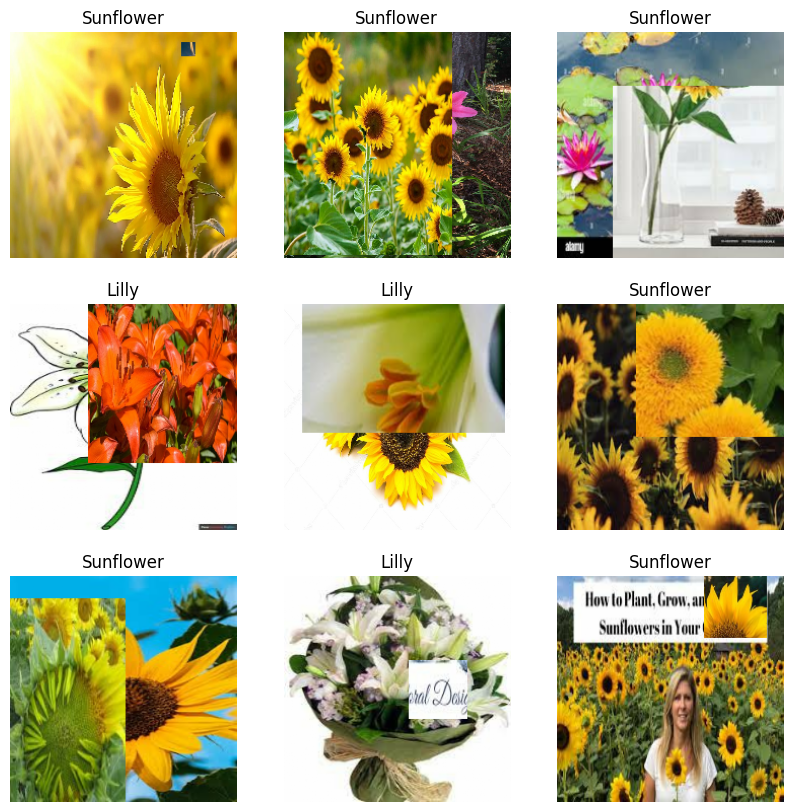

In [12]:
from data_loader import DataSet

dataset = DataSet(dataset_dir='flower_images')
train_data, val_data = dataset(validation_split=0.2)
t1 = train_data.map(lambda x, y: (x, y))
t2 = train_data.map(lambda x, y: (x, y))
td = tf.data.Dataset.zip((t1, t2))
train_ds_cmu = td.map(dataset.cutmix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

import matplotlib.pyplot as plt
import numpy as np

image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(label_batch[i].numpy())])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.show()

In [5]:
data_augmentation = keras.Sequential([
    # keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [6]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [7]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 512)  2048       ['activation[1][0]']         

In [8]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-256-8-{epoch}.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [13]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_ds_cmu, epochs=50, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=callbacks, verbose='auto')

Epoch 1/50
400/400 [==============================] - 178s 384ms/step - loss: 1.3984 - accuracy: 0.4630 - val_loss: 1.7174 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 165s 404ms/step - loss: 1.3511 - accuracy: 0.4877 - val_loss: 1.6974 - val_accuracy: 0.4690 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 162s 397ms/step - loss: 1.3036 - accuracy: 0.5207 - val_loss: 1.3228 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 163s 397ms/step - loss: 1.2661 - accuracy: 0.5247 - val_loss: 1.2540 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 163s 398ms/step - loss: 1.2343 - accuracy: 0.5587 - val_loss: 1.2867 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - 162s 399ms/step - loss: 1.2469 - accuracy: 0.5500 - val_loss: 1.2141 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 7/50
400/400 [==========================

Text(0.5, 0.98, 'Loss and Accuracy when using CutMix')

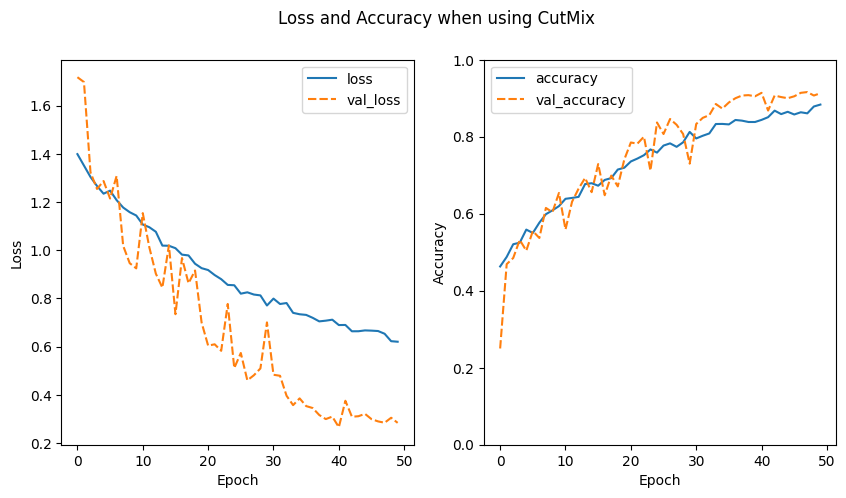

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy when using CutMix")